In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import pandas
import xlens
import treecorr
import astropy.io.ascii as pyascii
import numpy.lib.recfunctions as rfn
from lsst.geom import degrees

from lsst.daf.butler import Butler
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

In [2]:
def read_data(dtype):
    if dtype == "lowz0":
        lensargs = {
            'sample': 'LOWZ',
            'zmin': 0.0,
            'zmax': 0.3,
            'Magmin': -1000.0,
            'Magmax': -21.5
        }
    if dtype == "lowz":
        lensargs = {
            'sample': 'LOWZ',
            'zmin': 0.15,
            'zmax': 0.35,
            'Magmin': -1000.0,
            'Magmax': -21.5
        }
    elif dtype == "cmass1":
        lensargs = {
            'sample': 'CMASS',
            'zmin': 0.43,
            'zmax': 0.55,
            'Magmin': -24.0,
            'Magmax': -21.9
        }
    elif dtype == "cmass2":
        lensargs = {
            'sample': 'CMASS',
            'zmin': 0.55,
            'zmax': 0.70,
            'Magmin': -24.0,
            'Magmax': -22.2
        }
    if lensargs["sample"] == "LOWZ":
        df = pandas.read_csv("/work/sunao.sugiyama/catalogs/BOSS_DR11/LOWZ_K+E_v0.99.dat", delim_whitespace=1)
    elif lensargs["sample"] == "CMASS":
        df = pandas.read_csv("/work/sunao.sugiyama/catalogs/BOSS_DR11/CMASS_K+E_v0.99.dat", delim_whitespace=1)
    ra = df.ra.values
    dec = df.dec.values
    zred = df.z.values
    wt = (df.weight_noz.values + df.weight_cp.values - 1.0)* df.weight_star.values
    if 'mag_type' in lensargs:
        if lensargs['mag_type'] == 'Wake':
            iMag = df.Mag_Wake.values
        elif lensargs['mag_type'] == 'Blanton':
            iMag = df.Mag_Blanton.values
    else:
        iMag = df.Mag_Wake.values
    idx = (iMag>lensargs["Magmin"]) & (iMag<=lensargs["Magmax"]) & (zred>lensargs["zmin"]) & (zred<=lensargs["zmax"])
    
    ra = ra[idx]
    dec = dec[idx]
    zred = zred[idx]
    wt = wt[idx]
    #        print "sum wt:", np.sum(wt), len(ra)
    iMag = iMag[idx]
    # Define structured dtype
    dtype = [('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8'), ('i_mag', 'f8')]
    
    # Create structured array
    data = np.zeros(len(ra), dtype=dtype)
    data['ra'] = ra
    data['dec'] = dec
    data['z'] = zred
    data['w'] = wt
    data['i_mag'] = iMag
    return data

In [31]:
NSIDE = 1024
mask = hp.read_map("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window.fits", nest=True, dtype=bool)
for dtype in ["lowz", "cmass1", "cmass2"]:
    data = read_data(dtype)
    ra = data['ra']
    dec = data['dec']
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)
    pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
    mm = mask[pix]
    data = data[mm]
    fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/boss_dr11/%s.fits" % dtype
    pyfits.writeto(fname, data, overwrite=True)

/tmp/ipykernel_9226/2430126004.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pandas.read_csv("/work/sunao.sugiyama/catalogs/BOSS_DR11/LOWZ_K+E_v0.99.dat", delim_whitespace=1)
/tmp/ipykernel_9226/2430126004.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pandas.read_csv("/work/sunao.sugiyama/catalogs/BOSS_DR11/CMASS_K+E_v0.99.dat", delim_whitespace=1)
/tmp/ipykernel_9226/2430126004.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pandas.read_csv("/work/sunao.sugiyama/catalogs/BOSS_DR11/CMASS_K+E_v0.99.dat", delim_whitespace=1)


/tmp/ipykernel_9226/2430126004.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pandas.read_csv("/work/sunao.sugiyama/catalogs/BOSS_DR11/LOWZ_K+E_v0.99.dat", delim_whitespace=1)


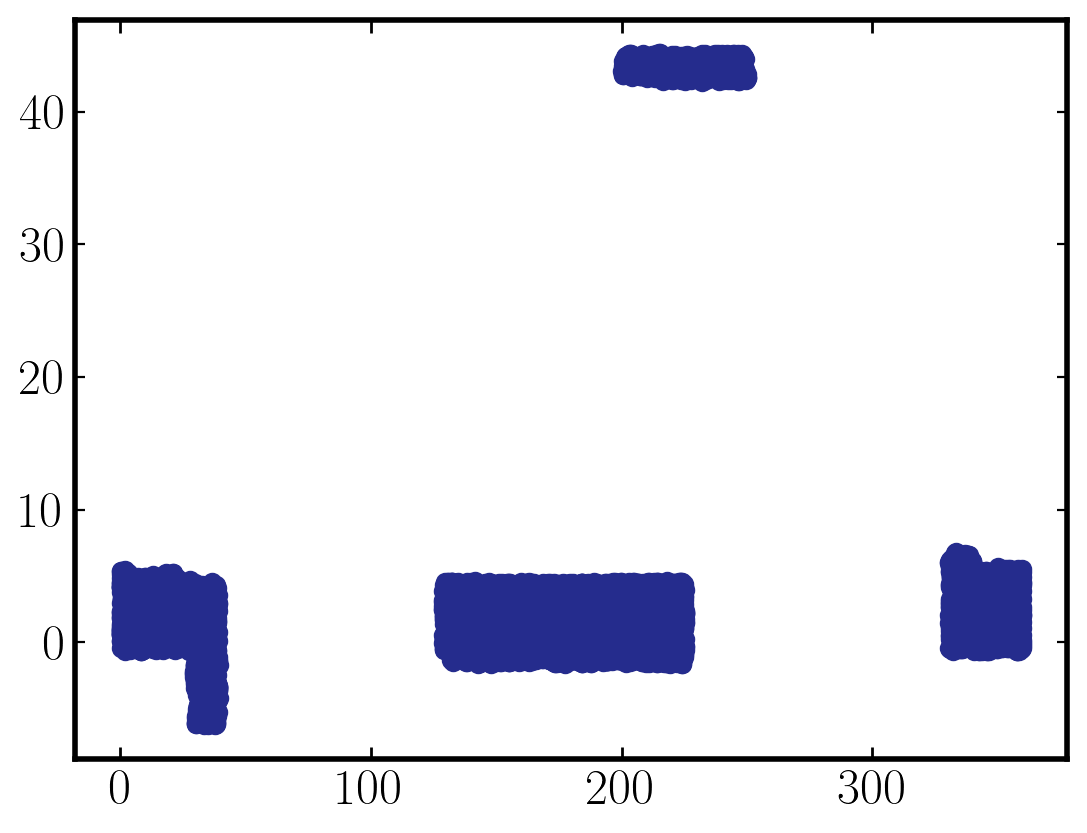

In [29]:
dd = read_data("lowz0")
plt.scatter(data["ra"], data["dec"])

In [26]:
len(dd)

75754

In [3]:
# Create x, y, yerr for all 8 plots
x_data = []
y_data = []
y_errs = []

def compute_xy(data_subset):
    arr = np.average(data_subset, axis=0)
    x  = arr[0]
    y1 = arr[1] / arr[3]
    y2 = arr[2] / arr[3]
    return x, y1, y2

for ff in ["lowz", "cmass1", "cmass2"]:
    data = fitsio.read(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/NG_{ff}.fits")
    # get the “nominal” values
    x, y1, y2 = compute_xy(data)
    
    # ---- bootstrap parameters ----
    nboot = 2000                      # number of bootstrap samples
    nreal = data.shape[0]             # how many realizations you have
    # pre-allocate arrays to hold each trial
    y1_boot = np.empty((nboot, y1.size))
    y2_boot = np.empty((nboot, y2.size))
    
    # ---- run the bootstrap ----
    for i in range(nboot):
        # sample `nreal` indices with replacement
        idx = np.random.choice(nreal, size=nreal, replace=True)
        # compute ratios on that resampled set
        _, y1_i, y2_i = compute_xy(data[idx])
        y1_boot[i] = y1_i
        y2_boot[i] = y2_i
    
    # ---- compute the 1-σ errors ----
    y1_err = np.std(y1_boot, axis=0)
    y2_err = np.std(y2_boot, axis=0)

    x_data.extend([x, x])
    y_data.extend([y1, y2])
    y_errs.extend([y1_err, y2_err])

4959.422335102491 14 0.0
1764.7340064504967 14 0.0
1147.187288797467 14 3.8931184444096864e-236
15.97393568576892 14 0.3149685934809011
19.925250028213526 14 0.13251578880137815
15.367587749383627 14 0.35349744386367765


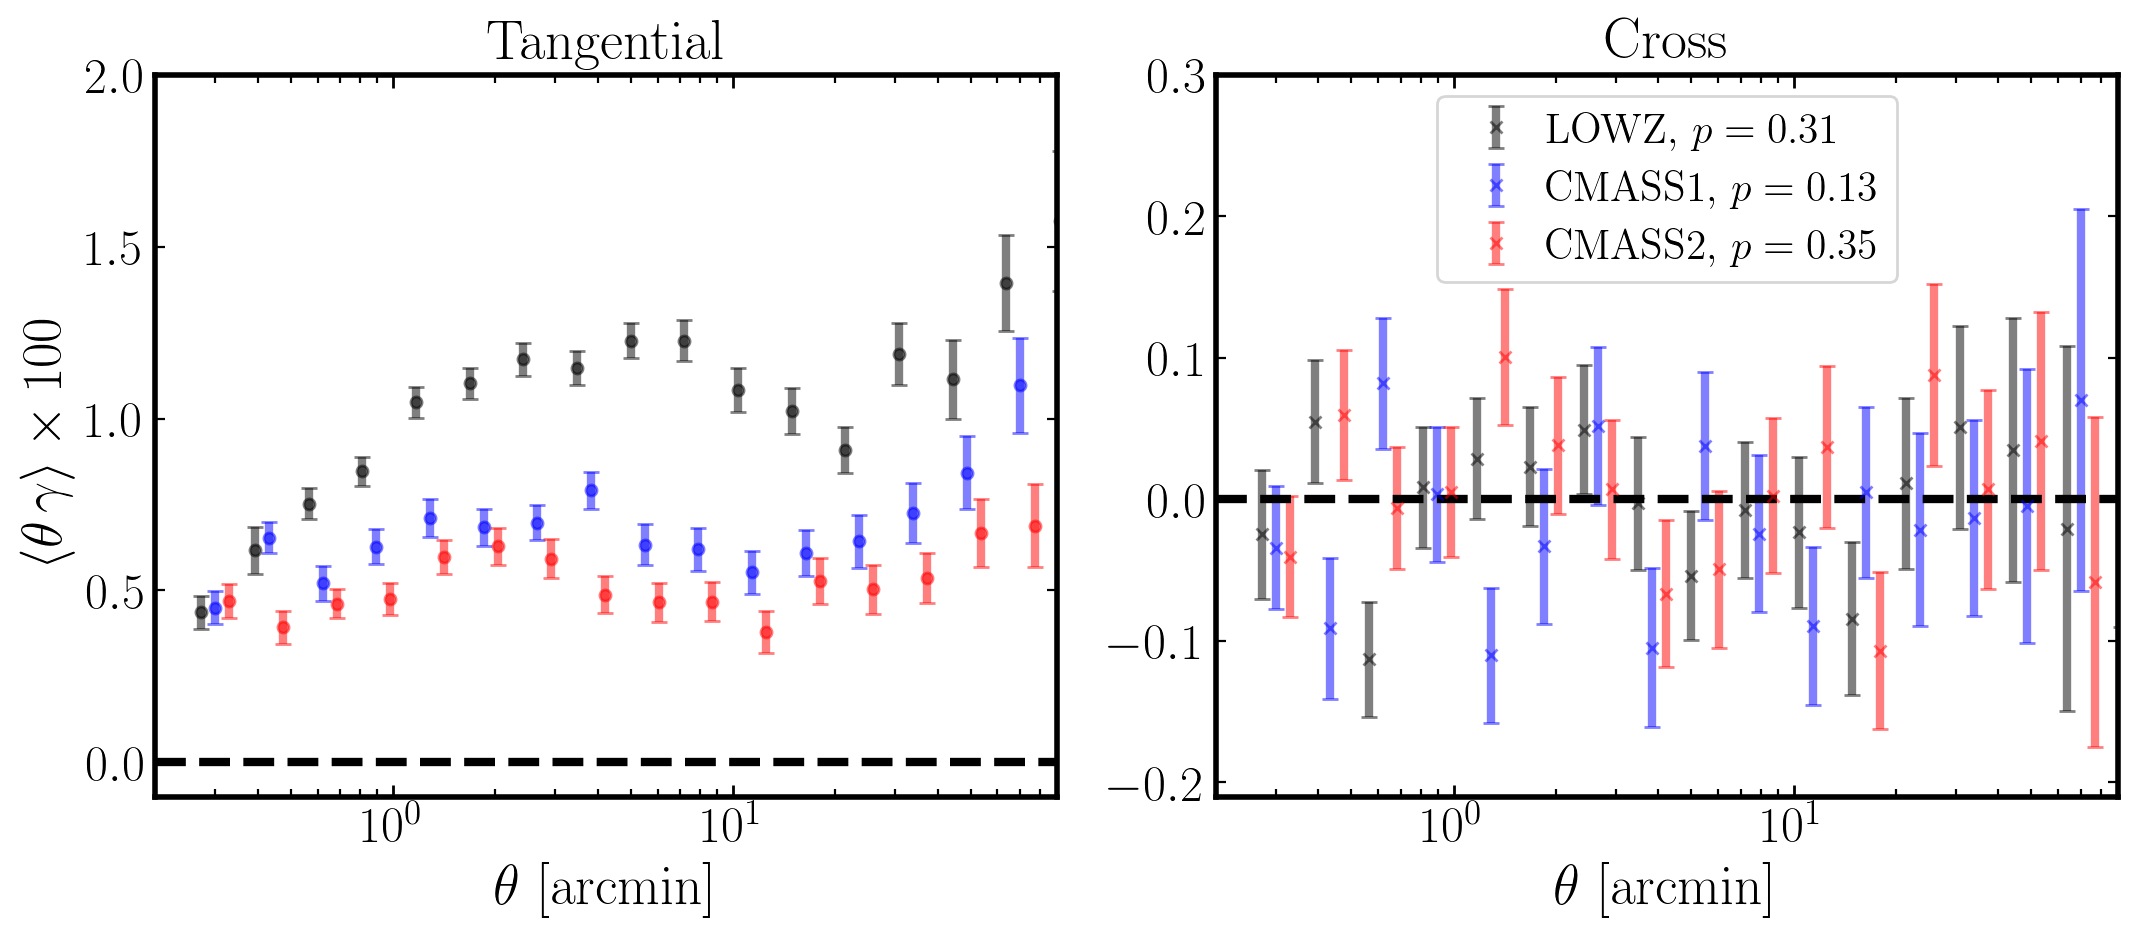

In [4]:
import scipy

multiply = 100
plt.close()

colors = ["black", "blue", "red"]
labels = ["LOWZ", "CMASS1", "CMASS2"]
rr = [1.0 / 1.10, 1.00, 1.10]

_, axes = plt.subplots(1, 2, figsize=(11, 5))
ax = axes[0]
istart = 1
iend = -5
for i in [0, 2, 4]:
    chi2 = np.sum((y_data[i][istart:iend] / y_errs[i][istart:iend]) ** 2.0)
    df = len(y_data[i][istart:iend])
    pv = scipy.stats.chi2.sf(chi2, df)
    ax.errorbar(
        x_data[i] * rr[i//2], 
        y_data[i] * x_data[i] * multiply, 
        y_errs[i] * x_data[i] * multiply,
        fmt='o', ms=4, capsize=3, linestyle='', alpha=0.5, 
        color=colors[i // 2],
        label=r"%s, $p =%.2f$" % (labels[i//2], pv),
    )
    print(chi2, df, pv)

ax.set_xscale('log')
#ax.legend(fontsize=15, loc="upper center", handletextpad=0.2)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Tangential")
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")
ax.set_ylabel(r"$\langle \theta\,\gamma \rangle \times 100$")
ax.set_xlim(0.2, 90)
ax.set_ylim(-0.1, 2.0)

ax = axes[1]
for i in [1, 3, 5]:
    chi2 = np.sum((y_data[i][istart:iend] / y_errs[i][istart:iend]) ** 2.0)
    df = len(y_data[i][istart:iend])
    pv = scipy.stats.chi2.sf(chi2, df)
    ax.errorbar(
        x_data[i] * rr[i//2], 
        y_data[i] * x_data[i] * multiply, 
        y_errs[i] * x_data[i] * multiply,
        fmt='x', ms=4, capsize=3, linestyle='', alpha=0.5,
        color=colors[i // 2],
        label=r"%s, $p =%.2f$" % (labels[i//2], pv),
    )
    print(chi2, df, pv)
ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper center", handletextpad=0.2)
ax.set_xlim(0.2, 90)
ax.set_ylim(-0.21, 0.3)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Cross")
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")

plt.tight_layout()
plt.show()

In [53]:
x_data[0][2:-3]

array([  0.62049076,   0.89259293,   1.28401935,   1.84709696,
         2.65709951,   3.82231032,   5.49849795,   7.90973971,
        11.37837694,  16.36810648,  23.54596891,  33.87152036,
        48.72510856,  70.09240151, 100.82983689])